# HW3: Bioinformatics
### Gene-Disease Research in the Post-Genomic Era
#### DS3000 - Gavin Wainwright

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns

In [2]:
# connect to the database
conn = sqlite3.connect('disgenet.db')

# select all the tables
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

# make sure we have a table for the disgenet and go_human files
for table in tables:
    print(table[0])

disgenet
go_human


### Question 1

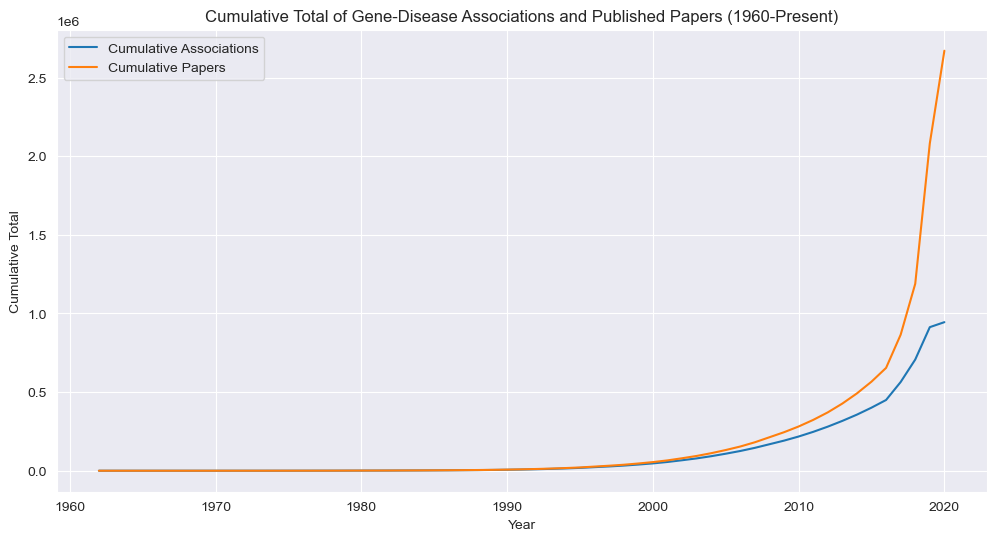

In [3]:
# query to extract the needed data from the gene-disease associations table
query = "SELECT last_year, COUNT(*) as num_associations, SUM(num_pubs) as num_pubs FROM disgenet WHERE last_year >= 1960 GROUP BY last_year"

# use pandas to run the SQL query and store the result in a dataframe
df = pd.read_sql_query(query, conn)

# compute the cumulative sums
df['cumulative_associations'] = df['num_associations'].cumsum()
df['cumulative_papers'] = df['num_pubs'].cumsum()

# plot cumulative totals
plt.figure(figsize=(12, 6))
plt.plot(df['last_year'], df['cumulative_associations'], label='Cumulative Associations')
plt.plot(df['last_year'], df['cumulative_papers'], label='Cumulative Papers')
plt.xlabel('Year')
plt.ylabel('Cumulative Total')
plt.title('Cumulative Total of Gene-Disease Associations and Published Papers (1960-Present)')
plt.legend()
plt.grid(True)
plt.show()

### How did the completion of the Human Genome project accelerate research in gene-disease associations?
As the provided visualization shows, the completion of the Human Genome Project corresponded with an increase in both the number of gene-disease associations identified and the number of research papers published. This is reflective of the increased research activity and the rapid pace of discovery in the field of genomics post-2003. As the understanding of the human genome continues to deepen, it is expected that there will be continued growth in the discovery of gene-disease associations and the development of targeted, genetic-based therapies.

### Question 2

In [4]:
query1 = """
SELECT gene_symbol, gene_name, COUNT(*) as num_associations, SUM(num_pubs) as total_papers
FROM disgenet
GROUP BY gene_symbol, gene_name
ORDER BY num_associations DESC
LIMIT 10;
"""

query2 = """
SELECT disease_name, COUNT(*) as num_associations, SUM(num_pubs) as total_papers
FROM disgenet
WHERE disease_type != 'group'
GROUP BY disease_name
ORDER BY num_associations DESC
LIMIT 10;
"""

df_genes = pd.read_sql_query(query1, conn)
df_diseases = pd.read_sql_query(query2, conn)

print("Top 10 genes with the most associations:")
print(df_genes)

print("\nTop 10 diseases with the most associations:")
print(df_diseases)

Top 10 genes with the most associations:
  gene_symbol                                          gene_name  \
0         TNF                              tumor necrosis factor   
1        TP53                                  tumor protein p53   
2         IL6                                      interleukin 6   
3       VEGFA               vascular endothelial growth factor A   
4        IL1B                                 interleukin 1 beta   
5        IL10                                     interleukin 10   
6       TGFB1                  transforming growth factor beta 1   
7        IFNG                                   interferon gamma   
8      PIK3CA  phosphatidylinositol-4,5-bisphosphate 3-kinase...   
9         CRP                                 C-reactive protein   

   num_associations  total_papers  
0              2724       21889.0  
1              2494       49257.0  
2              2367       15512.0  
3              1899       18185.0  
4              1801        927

### Question 3

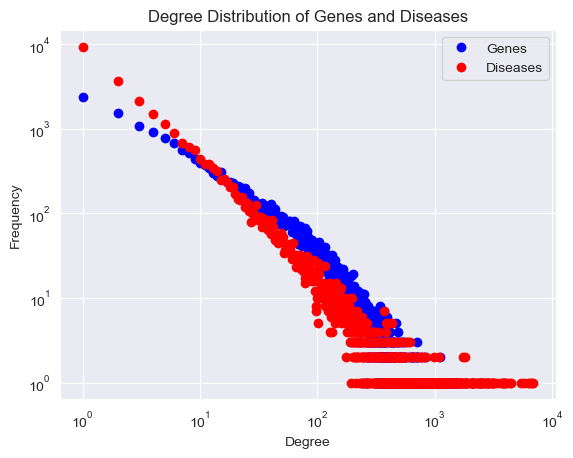

In [5]:
# queries to get the degree of each gene and disease
query_gene = """
SELECT gene_symbol, COUNT(*) as degree
FROM disgenet
GROUP BY gene_symbol;
"""

query_disease = """
SELECT disease_name, COUNT(*) as degree
FROM disgenet
WHERE disease_type != 'group'
GROUP BY disease_name;
"""

df_gene = pd.read_sql_query(query_gene, conn)
df_disease = pd.read_sql_query(query_disease, conn)

# create a histogram of degrees, in log scale
fig, ax = plt.subplots()

# count frequencies for genes
counts_gene = np.bincount(df_gene['degree'])
# overlay the degree distribution of diseases
counts_disease = np.bincount(df_disease['degree'])

# create an array with the indices
indices_gene = np.nonzero(counts_gene)[0]
indices_disease = np.nonzero(counts_disease)[0]

# plot on log-log scale
ax.loglog(indices_gene, counts_gene[indices_gene], marker='o', linestyle='None', color='b', label='Genes')
ax.loglog(indices_disease, counts_disease[indices_disease], marker='o', linestyle='None', color='r', label='Diseases')

# configure the layout
plt.title('Degree Distribution of Genes and Diseases')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

#### Question 4

In [6]:
# query to find genes strongly associated with alzheimer's
query = """
SELECT gene_symbol, gene_name, COUNT(*) as num_publications, AVG(EI) as avg_ei
FROM disgenet
WHERE disease_name = 'Alzheimer''s Disease' AND EI >= 0.667 AND num_pubs >= 11
GROUP BY gene_symbol, gene_name
ORDER BY num_publications DESC;
"""

df = pd.read_sql_query(query, conn)

# print the top 10 results
print(df.head(10))

  gene_symbol                                      gene_name  \
0         A2M                          alpha-2-macroglobulin   
1       ABCA1      ATP binding cassette subfamily A member 1   
2       ABCA2      ATP binding cassette subfamily A member 2   
3       ABCA7      ATP binding cassette subfamily A member 7   
4       ABCB1      ATP binding cassette subfamily B member 1   
5         ACE                angiotensin I converting enzyme   
6        ACHE  acetylcholinesterase (Cartwright blood group)   
7       ACOT7                        acyl-CoA thioesterase 7   
8        ACTB                                     actin beta   
9      ACTBL2                              actin beta like 2   

   num_publications  avg_ei  
0                 1  0.7692  
1                 1  0.9038  
2                 1  1.0000  
3                 1  0.9846  
4                 1  1.0000  
5                 1  0.9149  
6                 1  0.9845  
7                 1  1.0000  
8                 1  1.00

#### Question 5

In [7]:
# query to get Disease Pleiotropy Index (DPI) vs. the Disease Specificity Index (DSI)
query = """
SELECT gene_symbol, AVG(DSI) as avg_dsi, AVG(DPI) as avg_dpi, AVG(EI) as avg_ei, COUNT(*) as num_pubs
FROM disgenet
WHERE disease_name = 'Alzheimer''s Disease' AND EI >= 0.667 AND num_pubs >= 11
GROUP BY gene_symbol
ORDER BY num_pubs DESC;
"""

df_alz = pd.read_sql_query(query, conn)
df_alz

,gene_symbol,avg_dsi,avg_dpi,avg_ei,num_pubs
0,ZGLP1,0.512,0.808,1.0000,1
1,WWC1,0.610,0.692,0.9500,1
2,VSNL1,0.631,0.423,1.0000,1
3,VLDLR,0.558,0.692,0.8750,1
4,VEGFA,0.266,0.923,0.9189,1
...,...,...,...,...,...
309,ABCB1,0.344,0.885,1.0000,1
310,ABCA7,0.644,0.577,0.9846,1
311,ABCA2,0.670,0.615,1.0000,1
312,ABCA1,0.467,0.846,0.9038,1


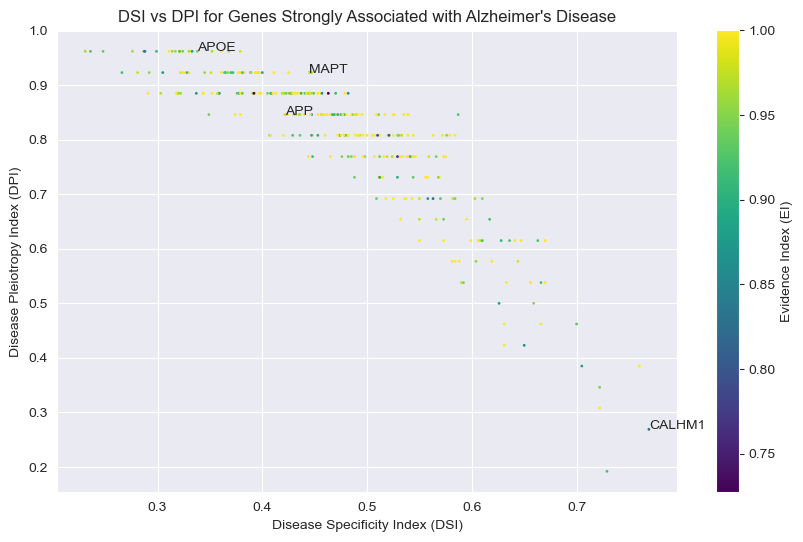

In [8]:
# create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_alz['avg_dsi'], df_alz['avg_dpi'], c=df_alz['avg_ei'], s=df_alz['num_pubs'], cmap='viridis')

# annotate specific genes
annotations = ['APOE', 'APP', 'MAPT', 'CALHM1']
for gene in annotations:
    gene_data = df_alz[df_alz['gene_symbol'] == gene]
    plt.text(gene_data['avg_dsi'], gene_data['avg_dpi'], gene)

# configure the layout
plt.colorbar(label='Evidence Index (EI)')
plt.xlabel('Disease Specificity Index (DSI)')
plt.ylabel('Disease Pleiotropy Index (DPI)')
plt.title('DSI vs DPI for Genes Strongly Associated with Alzheimer\'s Disease')
plt.grid(True)
plt.show()

#### Question 6

In [9]:
# query to get the biological processes that Alzheimer’s-linked genes are most frequently involved in
query = """
SELECT go_human.go_id, go_human.qualifier, go_human.go_term, COUNT(DISTINCT go_human.gene_id) as num_genes
FROM go_human
JOIN disgenet ON go_human.gene_id = disgenet.gene_id
WHERE disgenet.disease_name = 'Alzheimer''s Disease' AND disgenet.EI >= 0.667 AND disgenet.num_pubs >= 11
GROUP BY go_human.go_id, go_human.qualifier, go_human.go_term
ORDER BY num_genes DESC;
"""

df = pd.read_sql_query(query, conn)
df

,go_id,qualifier,go_term,num_genes
0,GO:0005515,enables,protein binding,275
1,GO:0005829,located_in,cytosol,141
2,GO:0005886,located_in,plasma membrane,127
3,GO:0005634,located_in,nucleus,103
4,GO:0005737,located_in,cytoplasm,102
...,...,...,...,...
5266,GO:2001260,involved_in,regulation of semaphorin-plexin signaling pathway,1
5267,GO:2001268,involved_in,negative regulation of cysteine-type endopepti...,1
5268,GO:2001269,involved_in,positive regulation of cysteine-type endopepti...,1
5269,GO:2001272,involved_in,positive regulation of cysteine-type endopepti...,1


#### Question 7

In [10]:
# query to identify the top 10 diseases, excluding Alzheimer's, that share the greatest number of gene associations with Alzheimer's
query = """
SELECT disgenet.disease_name, COUNT(DISTINCT disgenet.gene_symbol) as num_genes
FROM disgenet
WHERE disgenet.gene_symbol IN (
    SELECT gene_symbol
    FROM disgenet
    WHERE disease_name = 'Alzheimer''s Disease' AND EI >= 0.667 AND num_pubs >= 11
)
AND disgenet.disease_name != 'Alzheimer''s Disease'
AND disgenet.EI >= 0.667
AND disgenet.num_pubs >= 11
AND disgenet.disease_type != 'group'
GROUP BY disgenet.disease_name
ORDER BY num_genes DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df

,disease_name,num_genes
0,Malignant neoplasm of breast,124
1,Breast Carcinoma,123
2,Neoplasm Metastasis,109
3,Tumor Cell Invasion,101
4,Liver carcinoma,97
5,Carcinogenesis,95
6,Parkinson Disease,81
7,Atherosclerosis,78
8,"Diabetes Mellitus, Non-Insulin-Dependent",77
9,Obesity,76


#### Question 8

In [11]:
# query to find the top 10 diseases that share the most genes with Alzheimer's disease
query = """
SELECT disgenet.gene_id, disgenet.disease_name
FROM disgenet
WHERE disgenet.gene_id IN (
    SELECT gene_id
    FROM disgenet
    WHERE disease_name = 'Alzheimer''s Disease' AND EI >= 0.667 AND num_pubs >= 11
)
AND disgenet.disease_name IN (
    SELECT disease_name
    FROM (
        SELECT disgenet.disease_name, COUNT(DISTINCT disgenet.gene_id) as num_genes
        FROM disgenet
        WHERE disgenet.gene_id IN (
            SELECT gene_id
            FROM disgenet
            WHERE disease_name = 'Alzheimer''s Disease' AND EI >= 0.667 AND num_pubs >= 11
        )
        AND disgenet.disease_name != 'Alzheimer''s Disease'
        AND disgenet.EI >= 0.667
        AND disgenet.num_pubs >= 11
        AND disgenet.disease_type != 'group'
        GROUP BY disgenet.disease_name
        ORDER BY num_genes DESC
        LIMIT 10
    )
)
ORDER BY disgenet.num_pubs DESC
LIMIT 200;
"""

df = pd.read_sql_query(query, conn)
df

,gene_id,disease_name
0,2099.0,Malignant neoplasm of breast
1,2099.0,Breast Carcinoma
2,6622.0,Parkinson Disease
3,675.0,Malignant neoplasm of breast
4,675.0,Breast Carcinoma
...,...,...
195,2048.0,Liver carcinoma
196,23583.0,Breast Carcinoma
197,5054.0,Tumor Cell Invasion
198,23583.0,Malignant neoplasm of breast


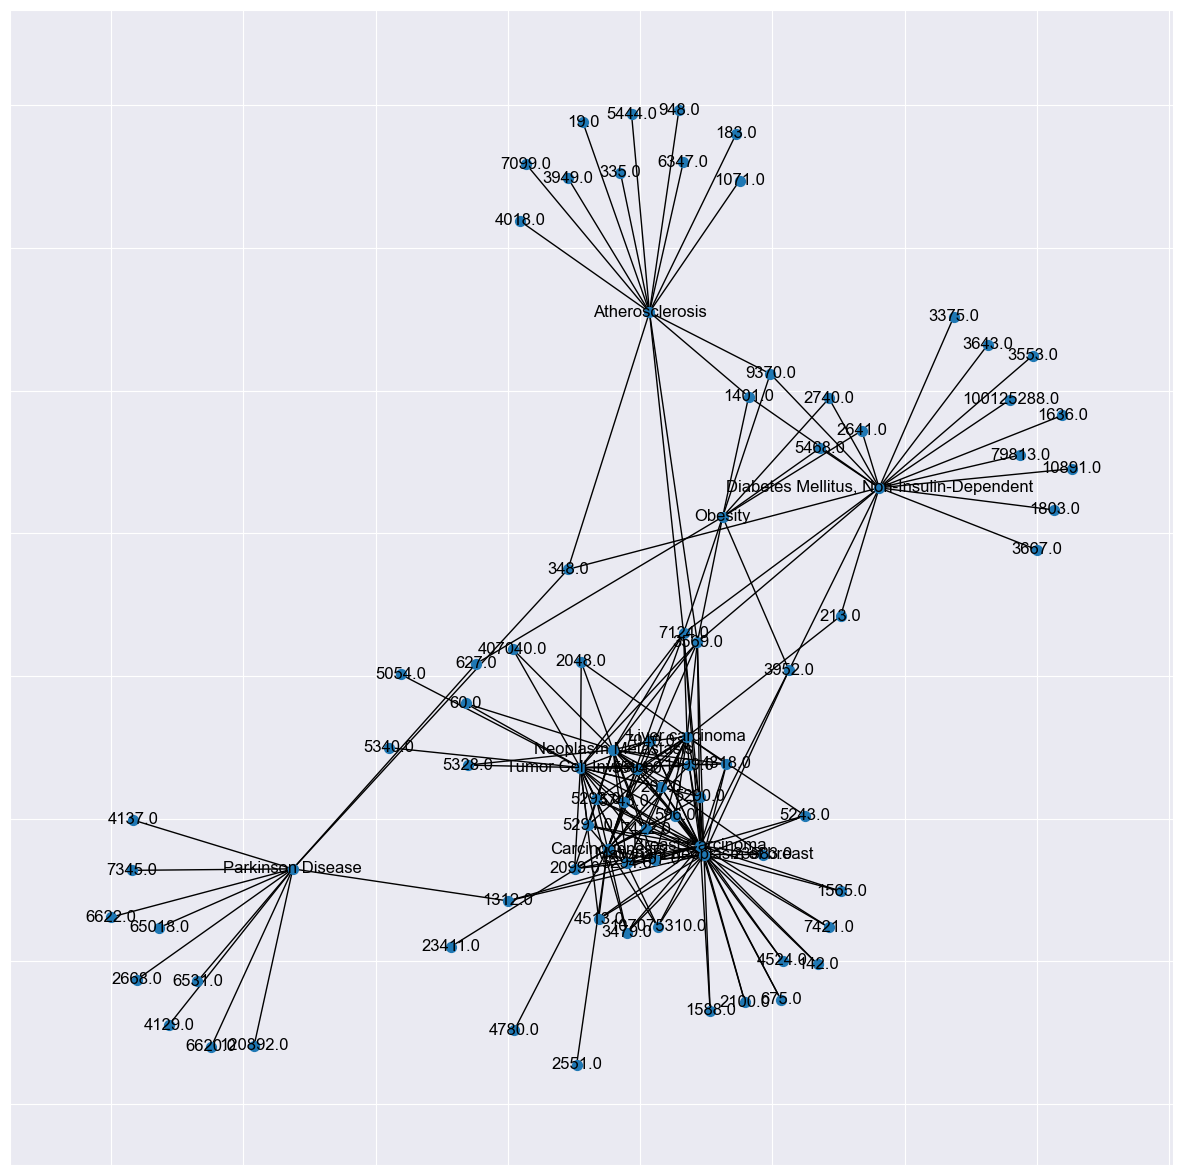

In [12]:
# create the graph
G = nx.from_pandas_edgelist(df, 'gene_id', 'disease_name', create_using=nx.Graph())

# draw the graph
plt.figure(figsize=(15,15), dpi=100)
nx.draw_networkx(G, with_labels=True, node_size=50)
plt.show()

### Open research initiative
What are the top 10 biological processes, in terms of gene count, involved in diseases that are most associated with Alzheimer's Disease?

In [13]:
query = """
SELECT go_human.go_term, COUNT(DISTINCT go_human.gene_id) as gene_count
FROM go_human
WHERE go_human.gene_id IN (
    SELECT disgenet.gene_id
    FROM disgenet
    WHERE disgenet.disease_name IN (
        SELECT disease_name
        FROM (
            SELECT disgenet.disease_name, COUNT(DISTINCT disgenet.gene_id) as num_genes
            FROM disgenet
            WHERE disgenet.gene_id IN (
                SELECT gene_id
                FROM disgenet
                WHERE disease_name = 'Alzheimer''s Disease' AND EI >= 0.667 AND num_pubs >= 11
            )
            AND disgenet.disease_name != 'Alzheimer''s Disease'
            AND disgenet.EI >= 0.667
            AND disgenet.num_pubs >= 11
            AND disgenet.disease_type != 'group'
            GROUP BY disgenet.disease_name
            ORDER BY num_genes DESC
            LIMIT 10
        )
    )
)
AND go_human.category = 'Process'
GROUP BY go_human.go_term
ORDER BY gene_count DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df

,go_term,gene_count
0,positive regulation of transcription by RNA po...,985
1,signal transduction,891
2,regulation of transcription by RNA polymerase II,875
3,negative regulation of transcription by RNA po...,733
4,positive regulation of DNA-templated transcrip...,580
5,apoptotic process,494
6,protein phosphorylation,455
7,negative regulation of DNA-templated transcrip...,445
8,miRNA-mediated gene silencing,442
9,positive regulation of gene expression,441


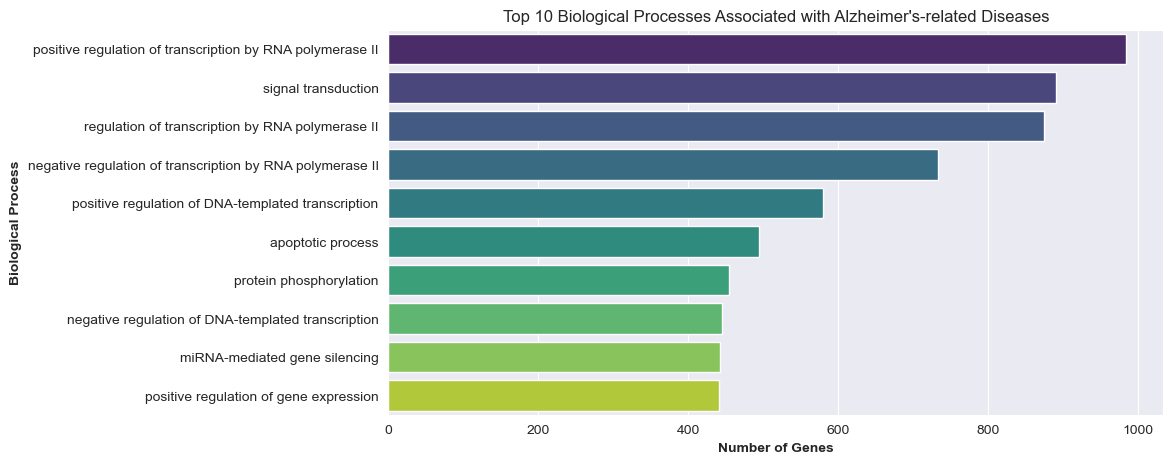

In [14]:
# plot the data
plt.figure(figsize=(10,5))
sns.barplot(x='gene_count', y='go_term', data=df, palette='viridis')
plt.title("Top 10 Biological Processes Associated with Alzheimer's-related Diseases")
plt.xlabel('Number of Genes', weight='bold')
plt.ylabel('Biological Process', weight='bold')
plt.show()